# Gabriella JC-DS-JKT-08 no. 3

Tujuan: prediksi apakah booking hotel dicancel atau tidak oleh customer

## Init

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns

In [96]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.preprocessing import RobustScaler, StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, classification_report

from sklearn.feature_selection import SelectKBest, chi2

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [5]:
df = pd.read_csv('hotel_bookings_clean.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   is_canceled                  3000 non-null   int64  
 1   lead_time                    3000 non-null   int64  
 2   arrival_date_month           3000 non-null   object 
 3   meal                         3000 non-null   object 
 4   market_segment               3000 non-null   object 
 5   distribution_channel         3000 non-null   object 
 6   reserved_room_type           3000 non-null   object 
 7   assigned_room_type           3000 non-null   object 
 8   booking_changes              3000 non-null   int64  
 9   deposit_type                 3000 non-null   object 
 10  days_in_waiting_list         3000 non-null   int64  
 11  customer_type                3000 non-null   object 
 12  adr                          3000 non-null   float64
 13  required_car_parki

In [7]:
target = 'is_canceled'
num_feats = [
    'lead_time', 'booking_changes', 'days_in_waiting_list', 'adr',
    'required_car_parking_spaces', 'total_of_special_requests', 'length_stay',
    'number_guest'
]
cat_feats = [
    'arrival_date_month', 'meal', 'market_segment', 'distribution_channel',
    'reserved_room_type', 'assigned_room_type', 'deposit_type',
    'customer_type', 'change_room_type'
]
1 + len(num_feats) + len(cat_feats) == len(df.columns)

True

## Encode Cats
Model tidak dapat memproses string/object, maka data kategorikal harus diwakilkan dengan angka. Semua variabel dapat digolongkan sebagai nominal karena tidak memiliki urutan (satu label tidak lebih baik daripada yang lainnya). Dalam hal ini penggunaan one-hot-encoding paling tepat.

In [8]:
onehot = OneHotEncoder()
for feat in ['arrival_date_month', 'meal', 'market_segment', 'distribution_channel',
    'reserved_room_type', 'assigned_room_type', 'deposit_type',
    'customer_type'
            ]:
    onehotvalue = onehot.fit_transform(df[feat].values.reshape(-1,1)).toarray()
    onehotcols = pd.DataFrame(onehotvalue, columns = [
        feat + '_' + str(onehot.categories_[0][i])
        for i in range(len(onehot.categories_[0]))
    ])
    df = pd.concat([df, onehotcols], axis = 1)
    print(f'{feat} encoded')
    df = df.drop(columns=feat)

arrival_date_month encoded
meal encoded
market_segment encoded
distribution_channel encoded
reserved_room_type encoded
assigned_room_type encoded
deposit_type encoded
customer_type encoded


In [9]:
df.describe()

,is_canceled,lead_time,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,length_stay,number_guest,change_room_type,...,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.354333,63.740667,0.210333,0.345667,105.005467,0.132000,0.728000,4.812000,2.191667,0.178333,...,0.049333,0.018667,0.006667,0.959333,0.040333,0.000333,0.066333,0.008333,0.821667,0.103667
std,0.478391,61.241921,0.641532,4.022716,54.367602,0.340511,0.868102,3.341114,2.054671,0.382857,...,0.216599,0.135367,0.081391,0.197550,0.196773,0.018257,0.248905,0.090921,0.382857,0.304878
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,0.000000,0.000000,61.350000,0.000000,0.000000,2.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,52.000000,0.000000,0.000000,100.680000,0.000000,0.000000,4.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,90.000000,0.000000,0.000000,138.850000,0.000000,1.000000,7.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,737.000000,17.000000,50.000000,299.330000,2.000000,4.000000,46.000000,55.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Raw

Mulai step ini, setiap ditetapkan random_state bertujuan supaya bisa reproduce hasil yang sama jika dirun berulang.

### Split Train/Test 80/20

In [12]:
X = df.drop(columns=target)
y = df[target]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,
                                                    random_state = 88)

for data in [x_train, x_test, y_train, y_test]:
    print(data.shape)

(2400, 51)
(600, 51)
(2400,)
(600,)


### Spot Check Classification Algorithms
Lihat model mana yang paling menjanjikan untuk prediksi booking cancellation (1 = canceled, 0 = not canceled).

Ada 2 jenis kesalahan yang mungkin terjadi dalam model ML di studi kasus ini, yaitu:

1. Model memprediksi user akan cancel booking (membatalkan pesanan), padahal sebenarnya/realisasinya user tidak membatalkan pesanan. --> FALSE POSITIVE
2. Model memprediksi user tidak membatalkan pesanan, padahal sebenarnya/realisasinya user cancel booking (membatalkan pesanan). --> FALSE NEGATIVE

Dalam konteks bisnis perhotelan, apabila pengunjung diasumsikan tidak cancel booking maka pihak hotel akan menyiapkan beberapa hal untuk menyambut kedatangan mereka, di antaranya:

* Menghubungi pengunjung terkait kapan perkiraan datang ke hotel,
* Membersihkan, merapikan, dan menyiapkan kamar sesuai pesanan pengunjung,
* Menyiapkan makanan dan minuman untuk menyambut kedatangan pengunjung,
* Menolak pengunjung lain yang memesan kamar yang telah dipesan (booked room), dan
* Memberi layanan penjemputan di bandara/stasiun/terminal apabila diperlukan.

**False negative** lebih costly untuk hotel, apalagi kondisi industri sekarang ini mengharuskan hotel untuk menekan cost habis-habisan untuk dapat survive. Penting bagi hotel untuk dapat mengenali booking yang 'genuine'.

Evaluasi akan berat pada metric (lebih tinggi lebih baik):
1. Recall 1/ precision 0
2. Test accuracy score (jika metric 1 imbang)

Sebelum dilakukan hyperparameter tuning semua model di bawah ini menggunakan hyperparameter default.

#### LogReg

C:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train score: 79.0%
Test score: 76.83%

              precision    recall  f1-score   support

           0       0.83      0.82      0.82       401
           1       0.64      0.67      0.66       199

    accuracy                           0.77       600
   macro avg       0.74      0.74      0.74       600
weighted avg       0.77      0.77      0.77       600



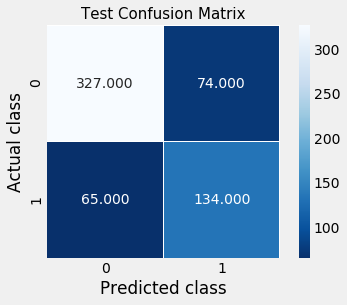

In [13]:
# LOGISTIC REGRESSION
classifier = LogisticRegression(solver='warn',
                                penalty='l2',
                                max_iter=100,
                                random_state=1
                               )
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

# METRICS
print(f'Train score: {round(classifier.score(x_train, y_train)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test, y_test)*100, 2)}%\n')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### DT

Train score: 99.67%
Test score: 75.83%

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       401
           1       0.62      0.69      0.66       199

    accuracy                           0.76       600
   macro avg       0.73      0.74      0.73       600
weighted avg       0.77      0.76      0.76       600



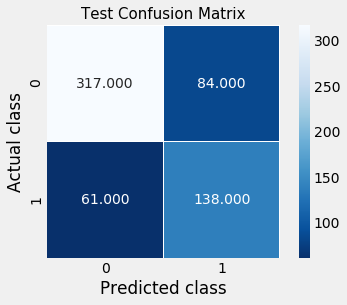

In [14]:
# DECISION TREE
classifier = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=None, 
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    random_state=1
                                   )
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

# METRICS
print(f'Train score: {round(classifier.score(x_train, y_train)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test, y_test)*100, 2)}%\n')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### RF

Train score: 99.67%
Test score: 79.83%

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       401
           1       0.69      0.71      0.70       199

    accuracy                           0.80       600
   macro avg       0.77      0.78      0.77       600
weighted avg       0.80      0.80      0.80       600



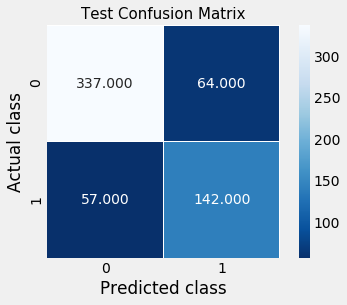

In [15]:
# RANDOM FOREST
classifier = RandomForestClassifier(criterion='gini', 
                                    max_depth=None, 
                                    min_samples_split=2, 
                                    min_samples_leaf=1, 
                                    n_estimators=100,
                                    random_state=1
                                   )
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

# METRICS
print(f'Train score: {round(classifier.score(x_train, y_train)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test, y_test)*100, 2)}%\n')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### KNN

Train score: 78.92%
Test score: 70.17%

              precision    recall  f1-score   support

           0       0.78      0.77      0.78       401
           1       0.55      0.56      0.55       199

    accuracy                           0.70       600
   macro avg       0.66      0.67      0.66       600
weighted avg       0.70      0.70      0.70       600



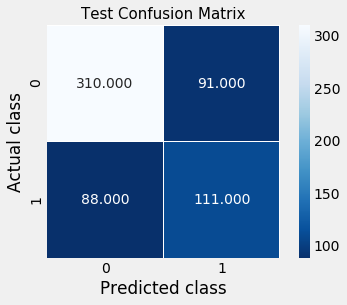

In [16]:
# K NEAREST NEIGHBORS
classifier = KNeighborsClassifier(n_neighbors=5,
                                  algorithm='auto'
                                 )
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

# METRICS
print(f'Train score: {round(classifier.score(x_train, y_train)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test, y_test)*100, 2)}%\n')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

## Robust

Transformasi data dengan robust scaler karena outliers masih ada pada dataset.

In [32]:
robust = RobustScaler()
df_robust = pd.DataFrame(robust.fit_transform(df[num_feats]), columns=num_feats)
df_robust = pd.concat([df_robust, df.drop(columns=num_feats)], axis=1)
df_robust.describe()

,lead_time,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,length_stay,number_guest,is_canceled,change_room_type,...,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
count,3000.000000,3000.000000,3000.000000,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.167724,0.210333,0.345667,5.581247e-02,0.132000,0.728000,0.162400,0.191667,0.354333,0.178333,...,0.049333,0.018667,0.006667,0.959333,0.040333,0.000333,0.066333,0.008333,0.821667,0.103667
std,0.874885,0.641532,4.022716,7.015174e-01,0.340511,0.868102,0.668223,2.054671,0.478391,0.382857,...,0.216599,0.135367,0.081391,0.197550,0.196773,0.018257,0.248905,0.090921,0.382857,0.304878
min,-0.742857,0.000000,0.000000,-1.299097e+00,0.000000,0.000000,-0.800000,-2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.457143,0.000000,0.000000,-5.074839e-01,0.000000,0.000000,-0.400000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,-9.150666e-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.542857,0.000000,0.000000,4.925161e-01,0.000000,1.000000,0.600000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,9.785714,17.000000,50.000000,2.563226e+00,2.000000,4.000000,8.400000,53.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


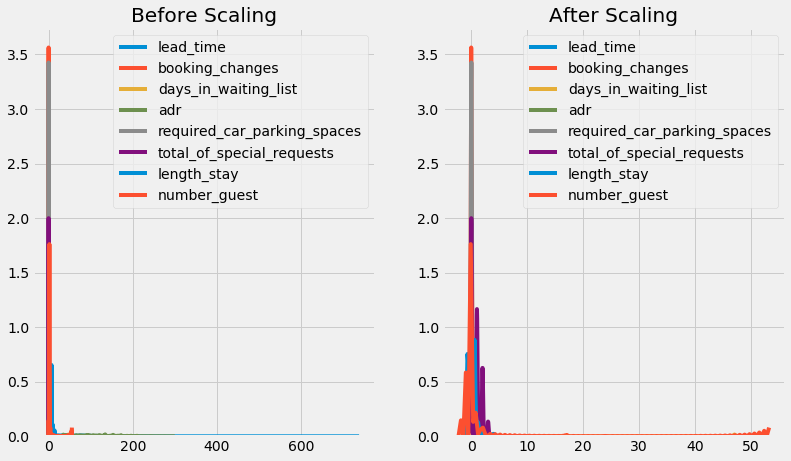

In [33]:
def viz_scaling(ori_dataset, new_dataset, feats):
    '''Function to visualize shape of features' distribution before and after scaling
       ori_dataset  = original dataset name
       new_dataset = new dataset name
       feats = list of features'''
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 7))
    
    ax1.set_title('Before Scaling')
    for feat in feats:
        sns.kdeplot(ori_dataset[feat], ax = ax1, bw=0.1)
    
    ax2.set_title('After Scaling')
    for feat in feats:
        sns.kdeplot(new_dataset[feat], ax = ax2, bw=0.1)
    
viz_scaling(df, df_robust, num_feats)    

### Split Train/Test 80/20

In [34]:
X_rob = df.drop(columns=target)
y_rob = df[target]

x_train_rob, x_test_rob, y_train_rob, y_test_rob = train_test_split(X_rob, y_rob, test_size = 0.20,
                                                    random_state = 88)

for data in [x_train_rob, x_test_rob, y_train_rob, y_test_rob]:
    print(data.shape)

(2400, 51)
(600, 51)
(2400,)
(600,)


### Spot Check Classification Algorithms

#### LogReg

C:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train score: 79.0%
Test score: 76.83%

              precision    recall  f1-score   support

           0       0.83      0.82      0.82       401
           1       0.64      0.67      0.66       199

    accuracy                           0.77       600
   macro avg       0.74      0.74      0.74       600
weighted avg       0.77      0.77      0.77       600



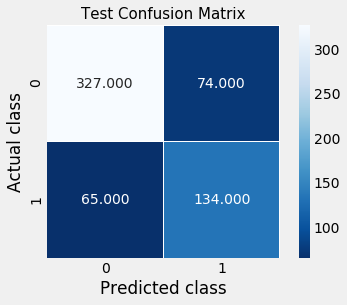

In [35]:
# LOGISTIC REGRESSION
classifier = LogisticRegression(solver='warn',
                                penalty='l2',
                                max_iter=100,
                                random_state=1
                               )
classifier.fit(x_train_rob, y_train_rob)
y_pred_rob = classifier.predict(x_test_rob)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob, y_train_rob)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob, y_test_rob)*100, 2)}%\n')

print(classification_report(y_test_rob, y_pred_rob))

cm = confusion_matrix(y_test_rob, y_pred_rob)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### DT

Train score: 99.67%
Test score: 75.83%

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       401
           1       0.62      0.69      0.66       199

    accuracy                           0.76       600
   macro avg       0.73      0.74      0.73       600
weighted avg       0.77      0.76      0.76       600



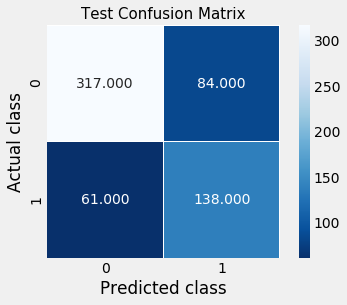

In [36]:
# DECISION TREE
classifier = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=None, 
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    random_state=1
                                   )
classifier.fit(x_train_rob, y_train_rob)
y_pred_rob = classifier.predict(x_test_rob)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob, y_train_rob)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob, y_test_rob)*100, 2)}%\n')

print(classification_report(y_test_rob, y_pred_rob))

cm = confusion_matrix(y_test_rob, y_pred_rob)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### RF

Train score: 99.67%
Test score: 79.83%

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       401
           1       0.69      0.71      0.70       199

    accuracy                           0.80       600
   macro avg       0.77      0.78      0.77       600
weighted avg       0.80      0.80      0.80       600



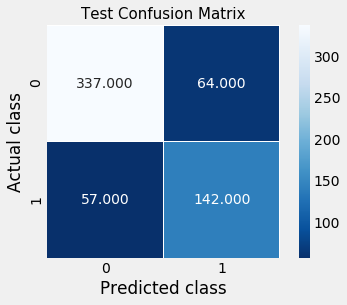

In [37]:
# RANDOM FOREST
classifier = RandomForestClassifier(criterion='gini', 
                                    max_depth=None, 
                                    min_samples_split=2, 
                                    min_samples_leaf=1, 
                                    n_estimators=100,
                                    random_state=1
                                   )
classifier.fit(x_train_rob, y_train_rob)
y_pred_rob = classifier.predict(x_test_rob)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob, y_train_rob)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob, y_test_rob)*100, 2)}%\n')

print(classification_report(y_test_rob, y_pred_rob))

cm = confusion_matrix(y_test_rob, y_pred_rob)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### KNN

Train score: 78.92%
Test score: 70.17%

              precision    recall  f1-score   support

           0       0.78      0.77      0.78       401
           1       0.55      0.56      0.55       199

    accuracy                           0.70       600
   macro avg       0.66      0.67      0.66       600
weighted avg       0.70      0.70      0.70       600



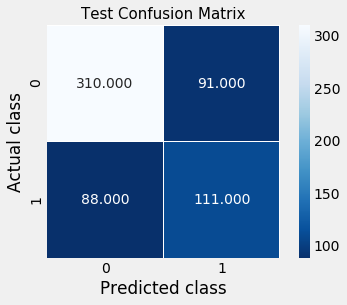

In [38]:
# K NEAREST NEIGHBORS
classifier = KNeighborsClassifier(n_neighbors=5,
                                  algorithm='auto'
                                 )
classifier.fit(x_train_rob, y_train_rob)
y_pred_rob = classifier.predict(x_test_rob)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob, y_train_rob)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob, y_test_rob)*100, 2)}%\n')

print(classification_report(y_test_rob, y_pred_rob))

cm = confusion_matrix(y_test_rob, y_pred_rob)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

## StandardScaler
Sebagai pembanding tambahan.

In [39]:
standard = StandardScaler()
df_standard = pd.DataFrame(standard.fit_transform(df[num_feats]), columns=num_feats)
df_standard = pd.concat([df_standard, df.drop(columns=num_feats)], axis=1)
df_standard.describe()

,lead_time,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,length_stay,number_guest,is_canceled,change_room_type,...,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
count,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,3.515706e-18,-6.456317e-16,-2.215552e-15,-1.800856e-15,-9.462061e-16,-4.689582e-16,2.121266e-16,-7.843356e-16,0.354333,0.178333,...,0.049333,0.018667,0.006667,0.959333,0.040333,0.000333,0.066333,0.008333,0.821667,0.103667
std,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,0.478391,0.382857,...,0.216599,0.135367,0.081391,0.197550,0.196773,0.018257,0.248905,0.090921,0.382857,0.304878
min,-1.040975e+00,-3.279155e-01,-8.594301e-02,-1.931720e+00,-3.877169e-01,-8.387512e-01,-1.440478e+00,-1.066853e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.143466e-01,-3.279155e-01,-8.594301e-02,-8.031023e-01,-3.877169e-01,-8.387512e-01,-8.417757e-01,-9.329896e-02,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,-1.917416e-01,-3.279155e-01,-8.594301e-02,-7.957290e-02,-3.877169e-01,-8.387512e-01,-2.430732e-01,-9.329896e-02,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,4.288518e-01,-3.279155e-01,-8.594301e-02,6.226167e-01,-3.877169e-01,3.133796e-01,6.549805e-01,-9.329896e-02,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.099527e+01,2.617556e+01,1.234554e+01,3.574867e+00,5.486782e+00,3.769772e+00,1.232968e+01,2.570589e+01,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


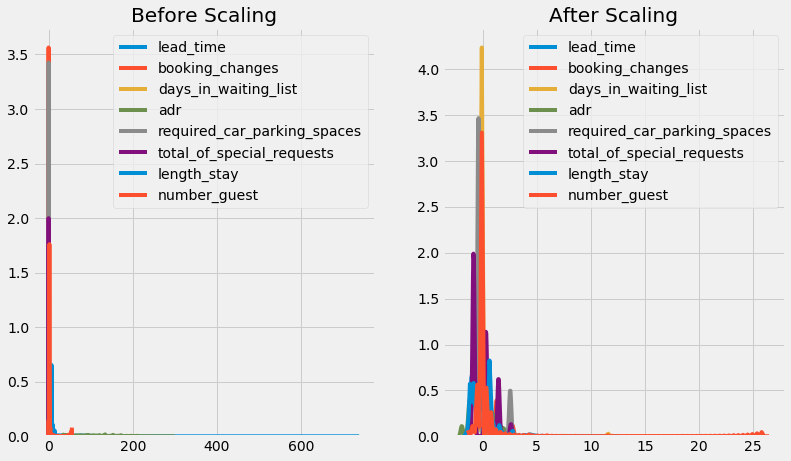

In [40]:
viz_scaling(df, df_standard, num_feats)    

### Split Train/Test 80/20

In [41]:
X_std = df_standard.drop(columns=target)
y_std = df_standard[target]

x_train_std, x_test_std, y_train_std, y_test_std = train_test_split(X_std, y_std, test_size = 0.20,
                                                    random_state = 88)

for data in [x_train_std, x_test_std, y_train_std, y_test_std]:
    print(data.shape)

(2400, 51)
(600, 51)
(2400,)
(600,)


### Spot Check Classification Algorithms

#### LogReg

C:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train score: 78.96%
Test score: 76.67%

              precision    recall  f1-score   support

           0       0.84      0.81      0.82       401
           1       0.64      0.68      0.66       199

    accuracy                           0.77       600
   macro avg       0.74      0.74      0.74       600
weighted avg       0.77      0.77      0.77       600



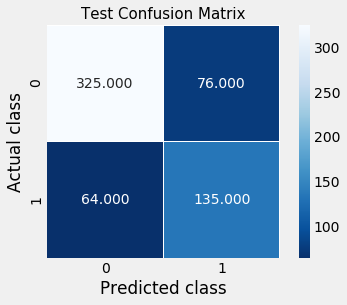

In [42]:
# LOGISTIC REGRESSION
classifier = LogisticRegression(solver='warn',
                                penalty='l2',
                                max_iter=100, 
                                random_state=1
                               )
classifier.fit(x_train_std, y_train_std)
y_pred_std = classifier.predict(x_test_std)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std, y_train_std)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std, y_test_std)*100, 2)}%\n')

print(classification_report(y_test_std, y_pred_std))

cm = confusion_matrix(y_test_std, y_pred_std)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### DT

Train score: 99.67%
Test score: 75.83%

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       401
           1       0.62      0.69      0.66       199

    accuracy                           0.76       600
   macro avg       0.73      0.74      0.73       600
weighted avg       0.77      0.76      0.76       600



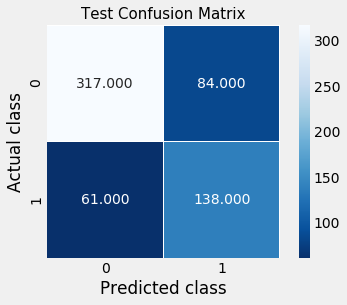

In [43]:
# DECISION TREE
classifier = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=None, 
                                    min_samples_split=2,
                                    min_samples_leaf=1, 
                                    random_state=1
                                   )
classifier.fit(x_train_std, y_train_std)
y_pred_std = classifier.predict(x_test_std)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std, y_train_std)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std, y_test_std)*100, 2)}%\n')

print(classification_report(y_test_std, y_pred_std))

cm = confusion_matrix(y_test_std, y_pred_std)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### RF

Train score: 99.67%
Test score: 79.67%

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       401
           1       0.69      0.71      0.70       199

    accuracy                           0.80       600
   macro avg       0.77      0.78      0.77       600
weighted avg       0.80      0.80      0.80       600



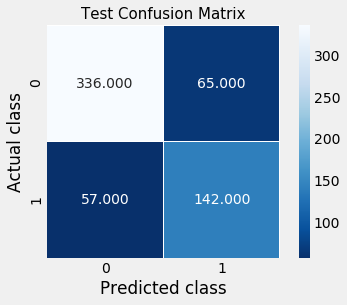

In [44]:
# RANDOM FOREST
classifier = RandomForestClassifier(criterion='gini', 
                                    max_depth=None, 
                                    min_samples_split=2, 
                                    min_samples_leaf=1, 
                                    n_estimators=100, 
                                    random_state=1
                                   )
classifier.fit(x_train_std, y_train_std)
y_pred_std = classifier.predict(x_test_std)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std, y_train_std)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std, y_test_std)*100, 2)}%\n')

print(classification_report(y_test_std, y_pred_std))

cm = confusion_matrix(y_test_std, y_pred_std)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### KNN

Train score: 85.58%
Test score: 73.5%

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       401
           1       0.58      0.71      0.64       199

    accuracy                           0.73       600
   macro avg       0.71      0.73      0.71       600
weighted avg       0.75      0.73      0.74       600



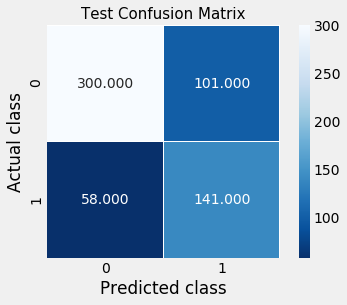

In [45]:
# K NEAREST NEIGHBORS
classifier = KNeighborsClassifier(n_neighbors=5,
                                  algorithm='auto'
                                 )
classifier.fit(x_train_std, y_train_std)
y_pred_std = classifier.predict(x_test_std)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std, y_train_std)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std, y_test_std)*100, 2)}%\n')

print(classification_report(y_test_std, y_pred_std))

cm = confusion_matrix(y_test_std, y_pred_std)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

## Comparing Raw/Robust/Standard

1. LogReg no diff
2. DT no diff
3. RF no diff
4. KNN much better with standardized data

Lanjutkan 2 model dengan recall 0 paling tinggi yaitu RF dengan KNN, scaling disamakan standard.

## Feature Selection

Jumlah kolom pada dataset tergolong besar (51 exclude target). Ini dapat menyebabkan overfitting & lamanya waktu training model. Untuk mengatasinya feature dapat diseleksi dengan harapan menghasilkan model dengan performa yang sama bahkan lebih baik, dengan input lebih sedikit.

### Method
Tested k=10, 20, 30

Best: k=30

In [64]:
bestfeatures = SelectKBest(score_func=chi2, k=30)

fit = bestfeatures.fit(X_rob, y_rob)

kbest = pd.DataFrame(zip(X_rob.columns, fit.scores_), columns = ['Feat','Score'])
print(kbest.nlargest(30,'Score'))

                             Feat        Score
0                       lead_time  7750.371895
3                             adr   785.855051
2            days_in_waiting_list   569.091895
45        deposit_type_Non Refund   220.486359
4     required_car_parking_spaces   217.319566
8                change_room_type   205.427587
1                 booking_changes    97.410304
21          market_segment_Groups    71.779508
35           assigned_room_type_A    63.069829
9       arrival_date_month_August    48.152401
22   market_segment_Offline TA/TO    45.453227
7                    number_guest    37.738103
47         customer_type_Contract    32.578134
40           assigned_room_type_F    27.042866
37           assigned_room_type_C    22.964269
20          market_segment_Direct    21.108137
10        arrival_date_month_July    15.903103
23       market_segment_Online TA    15.887583
50  customer_type_Transient-Party    15.489391
38           assigned_room_type_D    11.981449
48           

In [65]:
sel_feats = [feat for feat in kbest.nlargest(30,'Score')['Feat']]
sel_feats

['lead_time',
 'adr',
 'days_in_waiting_list',
 'deposit_type_Non Refund',
 'required_car_parking_spaces',
 'change_room_type',
 'booking_changes',
 'market_segment_Groups',
 'assigned_room_type_A',
 'arrival_date_month_August',
 'market_segment_Offline TA/TO',
 'number_guest',
 'customer_type_Contract',
 'assigned_room_type_F',
 'assigned_room_type_C',
 'market_segment_Direct',
 'arrival_date_month_July',
 'market_segment_Online TA',
 'customer_type_Transient-Party',
 'assigned_room_type_D',
 'customer_type_Group',
 'total_of_special_requests',
 'length_stay',
 'distribution_channel_Direct',
 'deposit_type_No Deposit',
 'assigned_room_type_I',
 'customer_type_Transient',
 'reserved_room_type_D',
 'assigned_room_type_B',
 'meal_SC']

### Split Train/Test 80/20

In [66]:
X_std_sel = df_standard[sel_feats]
y_std_sel = df_standard[target]

x_train_std_sel, x_test_std_sel, y_train_std_sel, y_test_std_sel = train_test_split(X_std_sel, 
                                                                                    y_std_sel, 
                                                                                    test_size = 0.20, 
                                                                                    random_state = 88
                                                                                   )

for data in [x_train_std_sel, x_test_std_sel, y_train_std_sel, y_test_std_sel]:
    print(data.shape)

(2400, 30)
(600, 30)
(2400,)
(600,)


### Spot Check Classification Algorithms

#### RF

Train score: 99.67%
Test score: 80.5%

              precision    recall  f1-score   support

           0       0.86      0.85      0.85       401
           1       0.70      0.71      0.71       199

    accuracy                           0.81       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.81      0.81      0.81       600



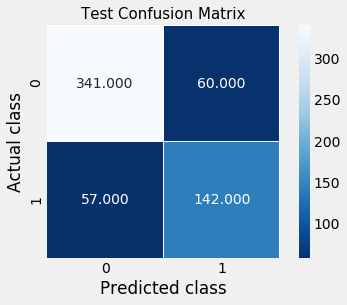

In [67]:
# RANDOM FOREST
classifier = RandomForestClassifier(criterion='gini', 
                                    max_depth=None, 
                                    min_samples_split=2, 
                                    min_samples_leaf=1, 
                                    n_estimators=100, 
                                    random_state=1
                                   )
classifier.fit(x_train_std_sel, y_train_std_sel)
y_pred_std_sel = classifier.predict(x_test_std_sel)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std_sel, y_train_std_sel)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std_sel, y_test_std_sel)*100, 2)}%\n')

print(classification_report(y_test_std_sel, y_pred_std_sel))

cm = confusion_matrix(y_test_std_sel, y_pred_std_sel)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### KNN

Train score: 84.67%
Test score: 75.33%

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       401
           1       0.61      0.70      0.65       199

    accuracy                           0.75       600
   macro avg       0.73      0.74      0.73       600
weighted avg       0.76      0.75      0.76       600



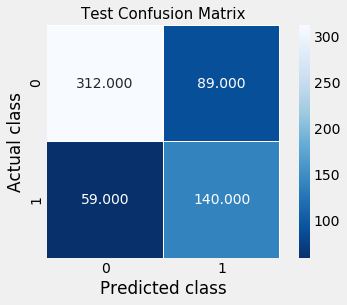

In [68]:
# K NEAREST NEIGHBORS
classifier = KNeighborsClassifier(n_neighbors=5,
                                  algorithm='auto'
                                 )
classifier.fit(x_train_std_sel, y_train_std_sel)
y_pred_std_sel = classifier.predict(x_test_std_sel)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std_sel, y_train_std_sel)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std_sel, y_test_std_sel)*100, 2)}%\n')

print(classification_report(y_test_std_sel, y_pred_std_sel))

cm = confusion_matrix(y_test_std_sel, y_pred_std_sel)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

## Feature Selection Result
Berhasil mengurangi feature dari 51 --> 30 dengan tetap menjaga performa model.

Interesting note:
Lead time, ADR, dan waktu tunggu di waitlist berandil besar dalam pertimbangan guest untuk membatalkan booking.

## Hyperparameter Tuning
Diketahui model2 sejauh ini memiliki masalah overfitting yang dapat dilihat dari train score > test score. Untuk mengatasi hal ini kita dapat mengurangi fleksibilitas model sehingga tidak overfit terhadap training data. Diharapkan model dapat meningkatkan performa pada test data.

### KNN

Success, recall 1 increased 2%

In [92]:
n_neighbors = [3, 5, 7, 9, 11, 13]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']

param = {'n_neighbors': n_neighbors, 'algorithm': algorithm}
param

{'n_neighbors': [3, 5, 7, 9, 11, 13],
 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

In [93]:
estimator = KNeighborsClassifier()
KNN_gridcv = GridSearchCV(
    estimator=estimator,
    param_grid=param,
    cv=5
)

KNN_gridcv.fit(x_train_std_sel, y_train_std_sel)
KNN_gridcv.best_params_

{'algorithm': 'brute', 'n_neighbors': 7}

Train score: 83.67%
Test score: 75.33%

              precision    recall  f1-score   support

           0       0.85      0.77      0.81       401
           1       0.61      0.72      0.66       199

    accuracy                           0.75       600
   macro avg       0.73      0.74      0.73       600
weighted avg       0.77      0.75      0.76       600



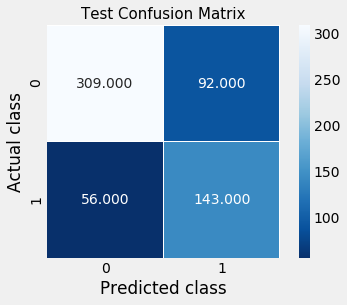

In [94]:
# K NEAREST NEIGHBORS
classifier = KNeighborsClassifier(n_neighbors=7, # changed
                                  algorithm='brute' # changed
                                 )
classifier.fit(x_train_std_sel, y_train_std_sel)
y_pred_std_sel = classifier.predict(x_test_std_sel)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std_sel, y_train_std_sel)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std_sel, y_test_std_sel)*100, 2)}%\n')

print(classification_report(y_test_std_sel, y_pred_std_sel))

cm = confusion_matrix(y_test_std_sel, y_pred_std_sel)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

### RF

Fail to increase recall 1

In [85]:
max_depth = [10, 30, 50, 70, 100, 200, 400, None]
min_samples_split = [2, 3, 4, 5, 10, 20, 30]
min_samples_leaf = [1, 2, 3, 4, 5, 10, 20]
n_estimators = [10, 20, 50, 100, 200, 500, 1000]

param = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 
         'min_samples_leaf': min_samples_leaf, 'n_estimators': n_estimators}
param

{'max_depth': [10, 30, 50, 70, 100, 200, 400, None],
 'min_samples_split': [2, 3, 4, 5, 10, 20, 30],
 'min_samples_leaf': [1, 2, 3, 4, 5, 10, 20],
 'n_estimators': [10, 20, 50, 100, 200, 500, 1000]}

In [86]:
estimator = RandomForestClassifier()
RF_randomcv = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param,
    cv=5
)

RF_randomcv.fit(x_train_std_sel, y_train_std_sel)
RF_randomcv.best_params_

{'n_estimators': 200,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_depth': 70}

Train score: 97.75%
Test score: 79.33%

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       401
           1       0.68      0.70      0.69       199

    accuracy                           0.79       600
   macro avg       0.77      0.77      0.77       600
weighted avg       0.79      0.79      0.79       600



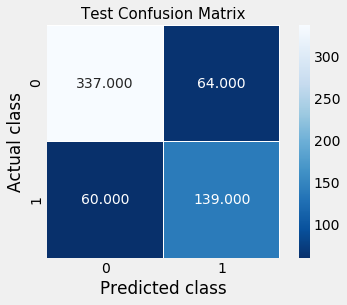

In [87]:
# RANDOM FOREST
classifier = RandomForestClassifier(criterion='gini', 
                                    max_depth=70, # changed
                                    min_samples_split=4,  # changed
                                    min_samples_leaf=1,
                                    n_estimators=200, # changed
                                    random_state=1
                                   )
classifier.fit(x_train_std_sel, y_train_std_sel)
y_pred_std_sel = classifier.predict(x_test_std_sel)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std_sel, y_train_std_sel)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std_sel, y_test_std_sel)*100, 2)}%\n')

print(classification_report(y_test_std_sel, y_pred_std_sel))

cm = confusion_matrix(y_test_std_sel, y_pred_std_sel)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

## Best Model

KNN with standardized data + feature selection + hyperparameter tuning wins

Train score: 83.67%
Test score: 75.33%

              precision    recall  f1-score   support

           0       0.85      0.77      0.81       401
           1       0.61      0.72      0.66       199

    accuracy                           0.75       600
   macro avg       0.73      0.74      0.73       600
weighted avg       0.77      0.75      0.76       600



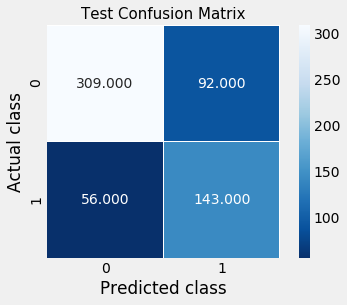

In [95]:
# K NEAREST NEIGHBORS
classifier = KNeighborsClassifier(n_neighbors=7,
                                  algorithm='brute'
                                 )
classifier.fit(x_train_std_sel, y_train_std_sel)
y_pred_std_sel = classifier.predict(x_test_std_sel)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std_sel, y_train_std_sel)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std_sel, y_test_std_sel)*100, 2)}%\n')

print(classification_report(y_test_std_sel, y_pred_std_sel))

cm = confusion_matrix(y_test_std_sel, y_pred_std_sel)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

Interpretasi test metrics:
* Model memiliki akurasi sebesar 75%.
* Model dapat mengenali 72% dari cancelled booking aktual.
* Model dapat menebak bahwa booking tidak dicancel dengan ketepatan 85%.